In [8]:
%matplotlib inline
#!/usr/bin/env python3
import os, sys, json
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from PlotUtils import *

allfields = ['loadfactor','memsize','timesecs','branchmisses','cachemisses','branches','instructions','cycles','pagefaults']


# Hash Map Evaluation

- Clients complain "application is too slow" 
- Consultant spends time debugging and breaking down at high cost
- Alternative: write application with well suited components
- Data containers have different characteristics
  - Generic or specialty
  - Memory usage: size per entry, access pattern
  - type of license: commercial, open source (gpl, lgpl, free)
  - interface: standard, C, C++, Python
  - performance: speed, cpu usage, cache impact
 
# Containers

## Standard
- std_map
- std_unordered_map
- python3_dict
- boost: unordered_map
- glib: tree, hash_table

## Github/FOSS
- carnegie melon: cuckoohash_map
- emilib: hash_map
- google: dense_hash_map, sparse_hash_map
- anonymous: khash
- skarupke: bytell_hash_map, flat_hash_map, flat_hash_map_power_of_two
- sparsepp: sparse_hash_map
- Tessil: array_map, hopscotch_map (w/store_hash), robin_map (w/store_hash), robin_pg_map, sparse_map

## Commercial 
- judy: HS and L
- leveldb (strings)
- rocksdb
- Qt: qhash
- kyotocabinet: hash, stash


# Tests 

## Integers
For the integers tests, we use hash maps with int64_t as key and int64_t as value.

- **insert_random_shuffle_range** 
Before the test, we generate a vector with the values \[0, nb_entries\) and shuffle this vector. Then for each value k in the vector, we insert the key-value pair (k, 1) in the hash map.
- **insert_random_full** 
Random full inserts: memory footprint and execution time (integers). 
Before the test, we generate a vector of nb_entries size where each value is randomly taken from an uniform random number generator from all possible positive values an int64_t can hold. Then for each value k in the vector, we insert the key-value pair (k, 1) in the hash map.
- **insert_random_full_reserve**
Random full inserts with reserve: execution time (integers)
Same as the random full inserts test but the reserve method of the hash map is called beforehand to avoid any rehash during the insertion. It provides a fair comparison even if the growth factor of each hash map is different.
- **reinsert_random_shuffle_range** 
Random shuffle inserts of existing keys: execution time (integers)
- **delete_random_full**
Random full deletes: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full insert test. 
We then delete each key one by one in a different and random order than the one they were inserted.
- **iteration_random_full**
Random full iteration: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full inserts test. 
We then use the hash map iterators to read all the key-value pairs
- **read_random_full**
Random full reads: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full inserts test. 
We then read each key-value pair in a different and random order than the one they were inserted.
- **read_miss_random_full**
Random full reads misses: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full inserts test. 
We then generate another vector of nb_entries random elements different from the inserted elements and 
we try to search for these unknown elements in the hash map.
- **read_random_full_after_delete**
Random full deletes: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full insert test. 
We then delete each key one by one in a different and random order than the one they were inserted.
- **read_random_shuffle_range**
Random shuffle reads: execution time (integers)
- **reinsert_random_full** 
Random full inserts of existing keys: execution time (integers)
Before the test, we generate a vector of nb_entries size where each
value is randomly taken from an uniform random number generator from
all possible positive values an int64_t can hold and insert the
key-value pairs (k, 1) in the hash map.  Then we shuffle the vector
and insert keys again.</p>


## Small strings
For the small string tests, we use hash maps with std::string as key and int64_t as value.
Each string is a random generated string of 10-20 alphanumeric characters (+1 for the null terminator). A generated key may look like "ju1AOoeWT3LdJxL".

- **insert_small_string**
Inserts: memory footprint and execution time (small strings)
For each entry in the range \[0, nb_entries\), we generate a string as key and insert it with the value 1.

- **reinsert_small_string**
Inserts of existing keys: execution time (small strings)
Before the test for each entry in the range [0, nb_entries), we generate a string as key and insert it with the value 1.  Then, we shuffle the vector of keys and insert them again

- **insert_small_string_reserve**
Inserts with reserve: memory footprint and execution time (small strings)
Same as the inserts test but the reserve method of the hash map is called beforehand to avoid any rehash during the insertion. It provides a fair comparison even if the growth factor of each hash map is different.

- **read_small_string**
Reads: execution time (small strings). 
Before the test, we insert nb_entries elements in the hash map as in the inserts test. 
We then read each key-value pair in a different and random order than the one they were inserted.

- **read_miss_small_string**
Reads misses: execution time (small strings). 
Before the test, we insert nb_entries elements in the same way as in the inserts test. 
We then generate nb_entries strings different from the inserted elements and 
we try to search for these unknown elements in the hash map.

- **delete_small_string**
Deletes: execution time (small strings)
Before the test, we insert nb_entries elements in the hash map as in the inserts test. 
We then delete each key one by one in a different and random order than the one they were inserted.

- **read_small_string_after_delete**
Reads after deleting half: execution time (small strings)
Before the test, we insert nb_entries elements in the same way as in the inserts test before 
deleting half of these values randomly. We then try to read all the original values in a 
different order which will lead to 50\% hits and 50\% misses.


## Strings

### Reads after deleting half: execution time (small strings)

Before the test, we insert nb_entries elements in the same way as in the inserts test before 
deleting half of these values randomly. We then try to read all the original values in a 
different order which will lead to 50% hits and 50% misses.

- **insert_string**
Inserts: memory footprint and execution time (strings)
For each entry in the range [0, nb_entries), we generate a string as key and insert it with the value 1.

- **insert_string_reserve**
Inserts with reserve: execution time (strings)
Same as the inserts test but the reserve method of the hash map is called beforehand to avoid any rehash during the insertion. 
It provides a fair comparison even if the growth factor of each hash map is different.

- **reinsert_string**
Inserts of existing keys: execution time (strings)
Before the test for each entry in the range [0, nb_entries), we generate a string as key and insert it with the value 1.  Then, we shuffle the vector of keys and insert them again.

- **read_string**
Reads: execution time (strings)
Before the test, we insert nb_entries elements in the hash map as in the inserts test. 
We then read each key-value pair in a different and random order than the one they were inserted.

- **read_miss_string**
Reads misses: execution time (strings)
Before the test, we insert nb_entries elements in the same way as in the inserts test. 
We then generate nb_entries strings different from the inserted elements and
we try to search for these unknown elements in the hash map.

- **delete_string**
Deletes: execution time (strings)
Before the test, we insert nb_entries elements in the hash map as in the inserts test. 
We then delete each key one by one in a different and random order than the one they were inserted.

- **read_string_after_delete**
Reads after deleting half: execution time (strings)
Before the test, we insert nb_entries elements in the same way as in the inserts test before deleting half of these values randomly. We then try to read all the original values in a different order which will lead to 50\% hits and 50\% misses.

# Metrics

- **Load Factor**
Percentage of used memory with respect of total allocated memory for the container

- **Memory Size**
Number of bytes allocated per hash entry 

- **Total Time**
Total executed time per hash entry

- **Branch Misses** 
Total number of branch misses per hash entry

- **Cache Misses**
Total number of cache misses per hash entry 

- **Branches**
Total number of branches per hash entry

- **Instructions**
Total number of instructions per hash entry 

- **Cycles**
Total number of cycles per hash entry

- **Page Faults**
Total number of page faults per hash entry 

# Test Runs

- AMD Ryzen Threadripper 3960X 24-Core Processor (24 cores no HT)

- Intel Xeon Platinum 8252C CPU @ 3.80GHz


In [9]:
amdfullname = 'output-amd-full'
#amdfull = load_data_file( amdfullname )
amdsoloname = 'output-amdsolo-perfcounter'
amdsolo = load_data_file( amdsoloname )
intelfullname = 'output-xeon8252c-full'
#intelfull = load_data_file( intelfullname )
intelsoloname = 'output-xeon8252c-solo'
#intelsolo = load_data_file( intelsoloname )

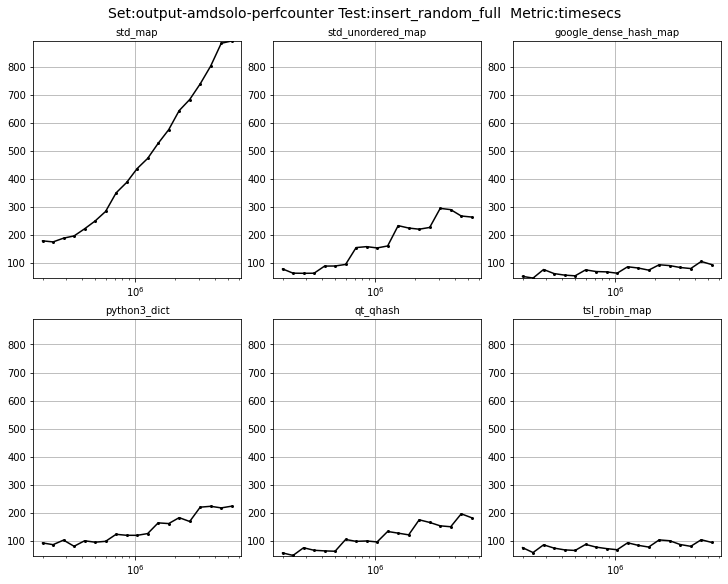

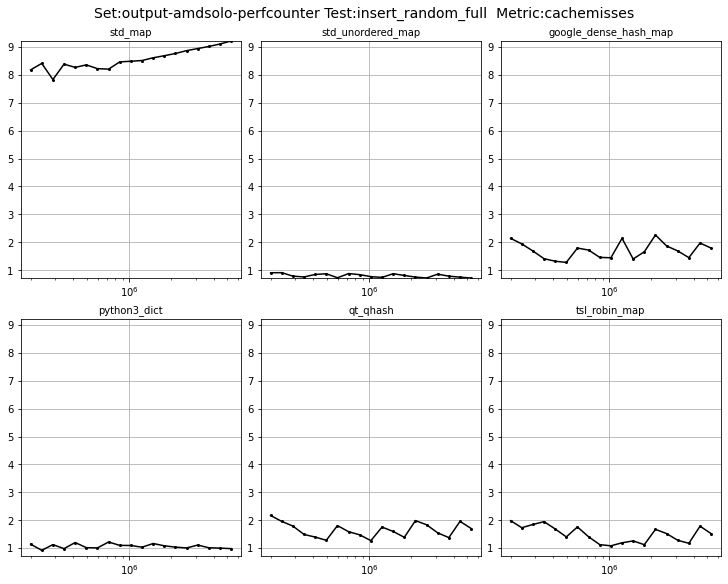

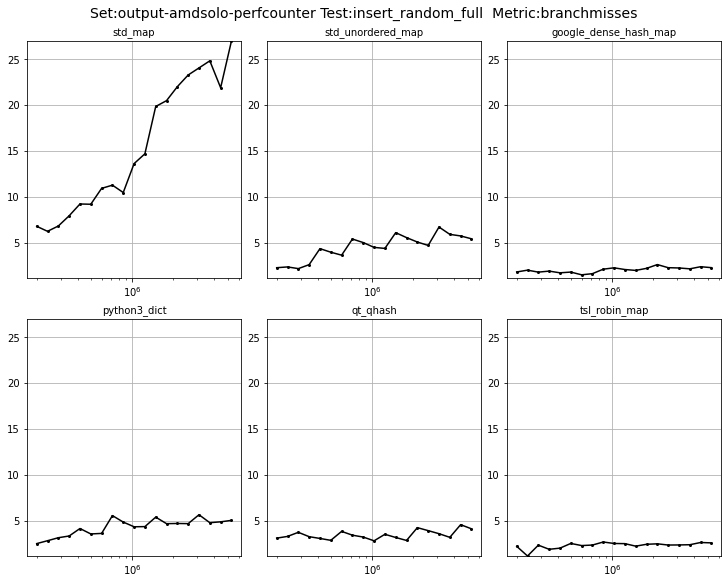

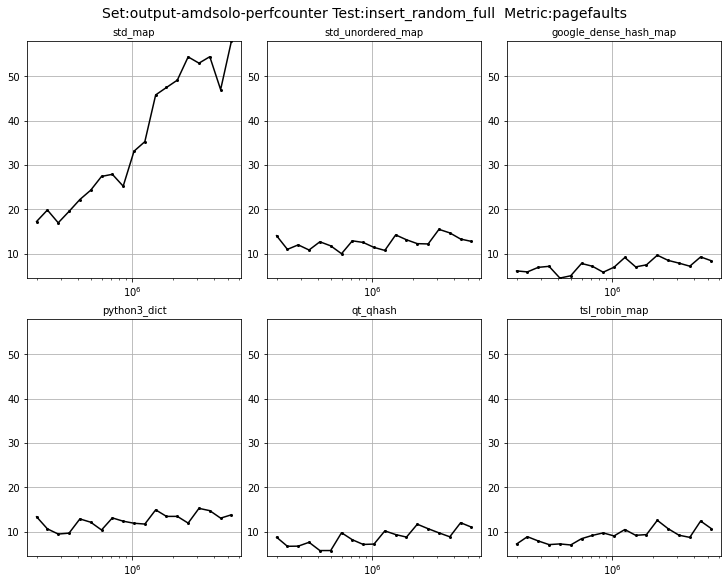

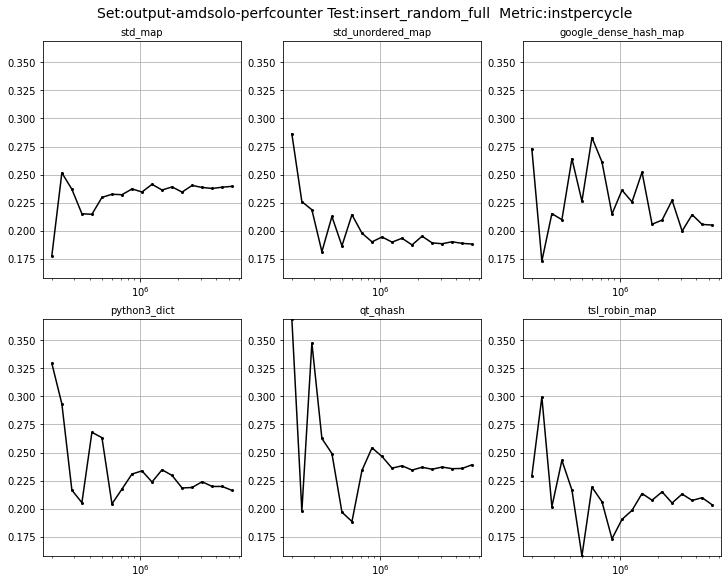

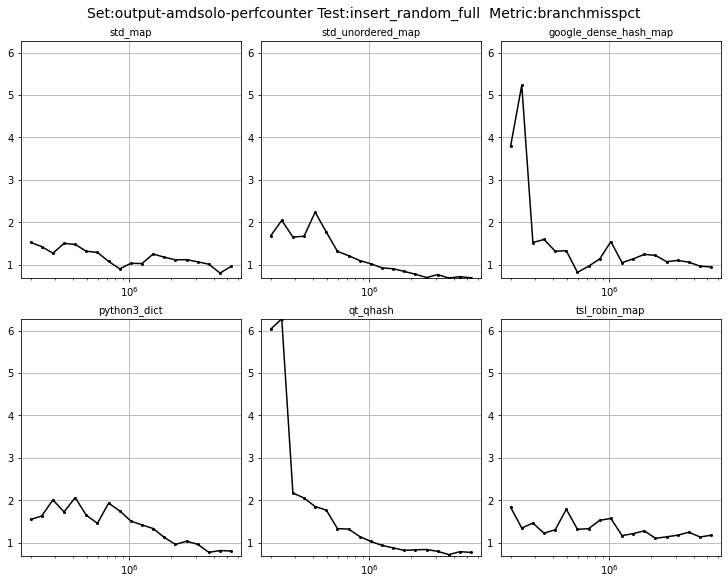

In [17]:
mymetrics = ('timesecs','cachemisses','branchmisses','pagefaults','instpercycle','branchmisspct')
myct = ('google_dense_hash_map','std_unordered_map','qt_qhash','ska_bytell_hash_map','judyL','tsl_robin_map','boost_unordered_map')
mytests = ('insert_random_full',)
#plot_containers( amdsoloname, amdsolo, mymetrics, myct, mytests )
myct = ('google_dense_hash_map','std_map','python3_dict','std_unordered_map','qt_qhash','tsl_robin_map')
plot_containers( amdsoloname, amdsolo, mymetrics, myct,mytests)
#plot_containers( intelsoloname, intelsolo, mymetrics, myct, mytests )
#plot_containers( amdfullname, amdfull, mymetrics, myct, mytests )
#plot_containers( intelfullname, intelfull, mymetrics, myct, mytests )

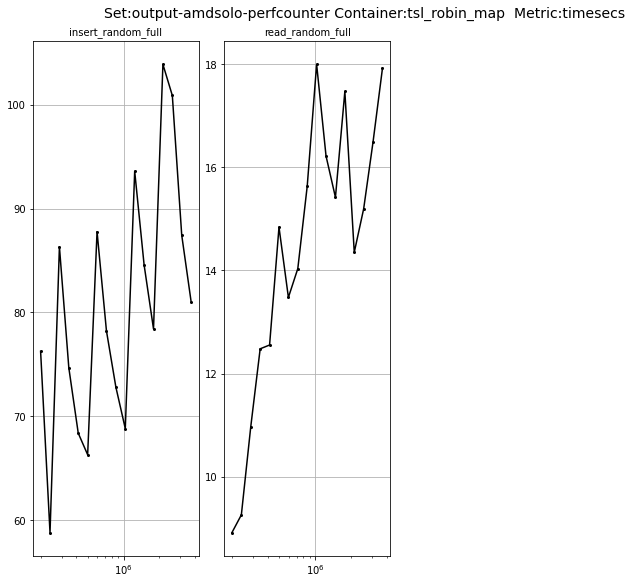

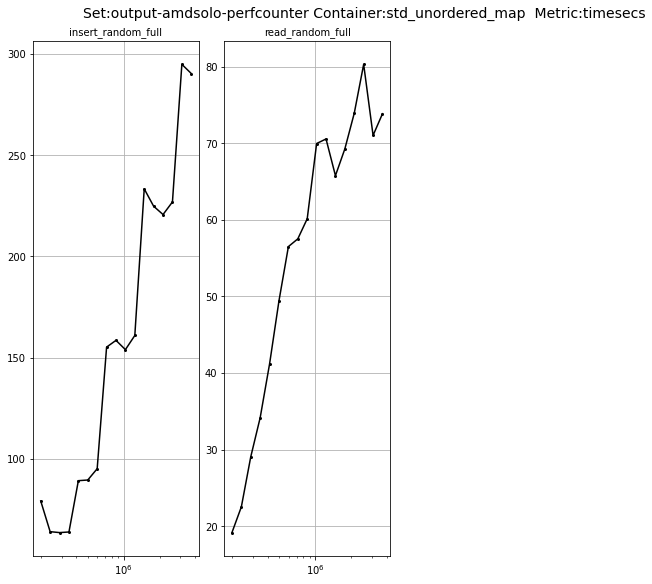

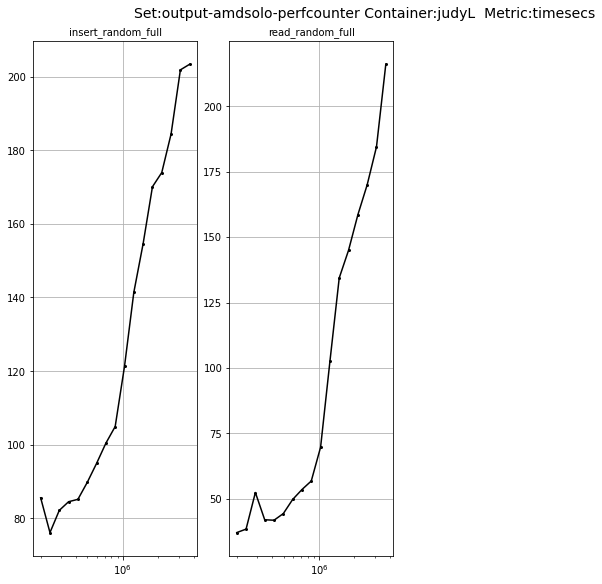

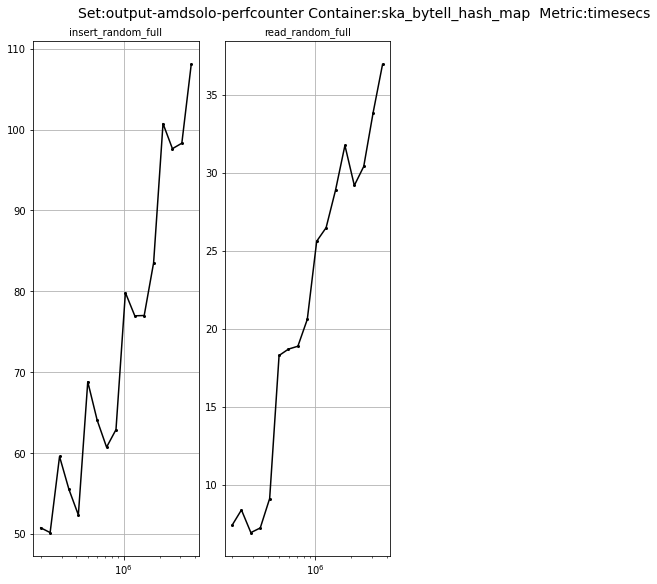

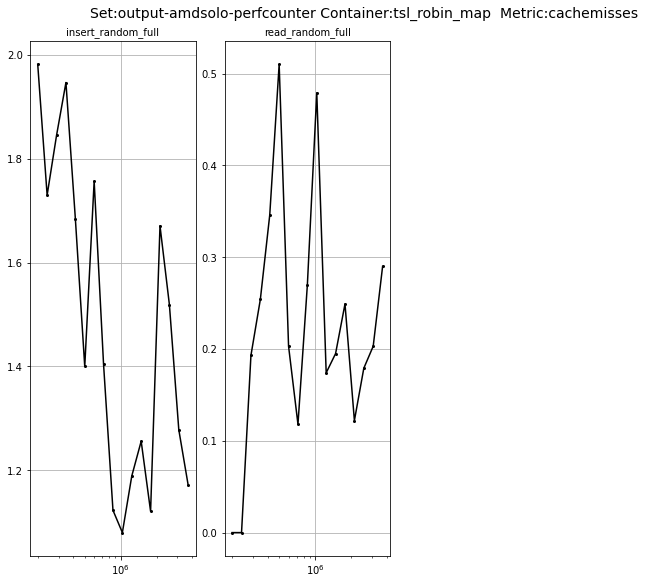

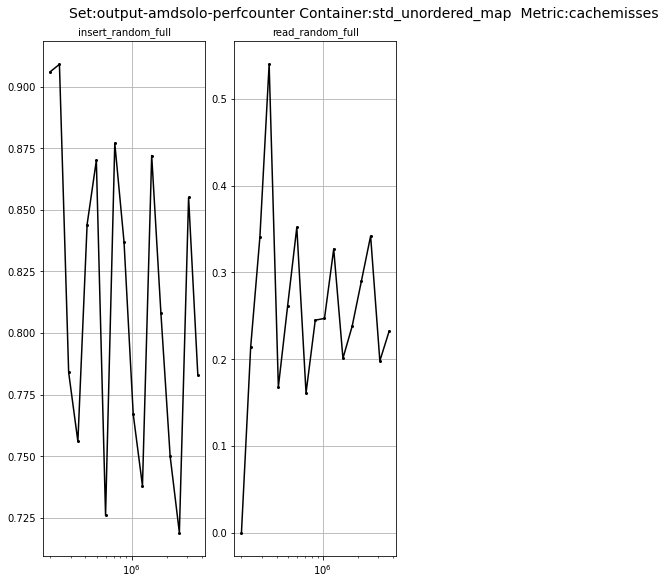

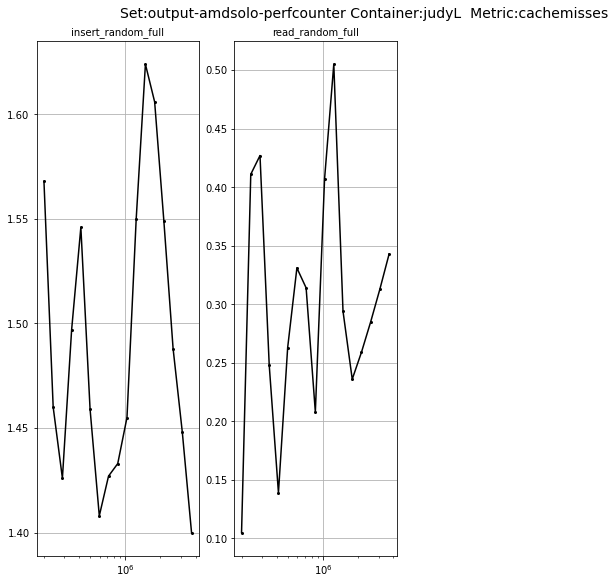

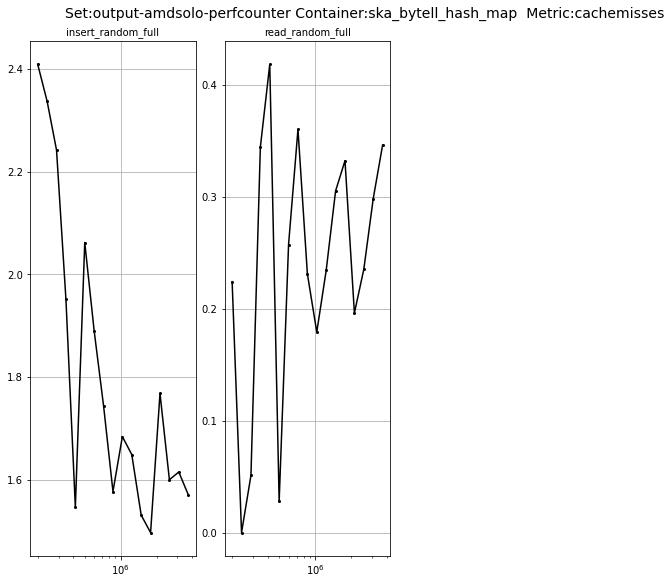

In [17]:
mymetrics = ('timesecs','cachemisses')
myct = ('std_unordered_map','ska_bytell_hash_map','judyL','tsl_robin_map')
mytests = ('insert_random_full','read_random_full',)
plot_tests( amdsoloname, amdsolo, mymetrics, myct, mytests )
#plot_tests( intelsoloname, intelsolo, mymetrics, myct, mytests )
#plot_tests( amdfullname, amdfull, mymetrics, myct, mytests )
#plot_tests( intelfullname, intelfull, mymetrics, myct, mytests )


In [5]:
tests = ('cachemisses','branchmisses')
plot_containers( amdfullname, amdfull, ('instructions',), myct, tests )
plot_containers( intelfullname, intelfull, ('instructions',), myct, tests )